In [1]:
import numpy as np
import tensorflow as tf
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Tensorflow and Deep Learning

In this lab assignment, first you will learn how to build and train a neural network that recognises handwritten digits, and then you will build LeNet-5 CNN architecture, which is widely used for handwritten digit recognition. At the end of this lab assignment, you will make AlexNet CNN architecture, which won the 2012 ImageNet ILSVRC challenge.

---
# 1. Dataset
In the first part of the assignment, we use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. There are 70,000 images, and each image has 784 features. This is because each image is 28×28=784 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). The following figure shows a few images from the MNIST dataset to give you a feel for the complexity of the classification task.

<img src="figs/1-mnist.png" style="width: 300px;"/>

To begin the assignment, first, use `mnist_data.read_data_sets` and download images and labels. It return two lists, called `mnist.test` with 10K images+labels, and `mnist.train` with 60K images+labels.

In [2]:
# TODO: Replace <FILL IN> with appropriate code

from tensorflow.examples.tutorials.mnist import input_data as mnist_data

mnist = mnist_data.read_data_sets("./Datasets/MNIST/", one_hot=True)

Extracting ./Datasets/MNIST/train-images-idx3-ubyte.gz
Extracting ./Datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting ./Datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting ./Datasets/MNIST/t10k-labels-idx1-ubyte.gz


---
# 2. A One-Layer Neural Network
<img src="figs/2-comic1.png" style="width: 500px;"/>

Let's start by building a one-layer neural network. Handwritten digits in the MNIST dataset are 28x28 pixel greyscale images. The simplest approach for classifying them is to use the 28x28=784 pixels as inputs for a **one-layer neural network**. Each neuron in the network does a weighted sum of all of its inputs, adds a bias and then feeds the result through some non-linear activation function. Here we design a one-layer neural network with 10 output neurons since we want to classify digits into 10 classes (0 to 9).
<img src="figs/3-one_layer.png" style="width: 400px;"/>


For a classification problem, an *activation function* that works well is **softmax**. Applying softmax on a vector is done by taking the exponential of each element and then normalising the vector.
<img src="figs/4-softmax.png" style="width: 300px;"/>

We can summarise the behaviour of this single layer of neurons into a simple formula using a *matrix multiply*. If we give input data into the network in *mini-batch* of 100 images, it produces 100 predictions as the output. We define the **weights matrix $W$** with 10 columns, in which each column indicates the weight of a one class (a single digit), from 0 to 9. Using the first column of $W$, we can compute the weighted sum of all the pixels of the first image. This sum corresponds to the first neuron that points to the number 0. Using the second column of $W$, we do the same for the second neuron (number 1) and so on until the 10th neuron. We can then repeat the operation for the remaining 99 images in the mini-batch. If we call $X$ the matrix containing our 100 images (each row corresponds to one digit), all the weighted sums for our 10 neurons, computed on 100 images are simply $X.W$. Each neuron must now add its bias. Since we have 10 neurons, we have 10 bias constants. We finally apply the **softmax activation function** and obtain the formula describing a one-layer neural network, applied to 100 images.
<img src="figs/5-xw.png" style="width: 600px;"/>
<img src="figs/6-softmax2.png" style="width: 500px;"/>

Then, we need to use the **cross-entropy** to measure how good the predictions are, i.e., the distance between what the network tells us and what we know to be the truth. The cross-entropy is a function of weights, biases, pixels of the training image and its known label. If we compute the partial derivatives of the cross-entropy relatively to all the weights and all the biases, we obtain a **gradient**, computed for a given image, label and present value of weights and biases. We can update weights and biases by a fraction of the gradient and do the same thing again using the next batch of training images.
<img src="figs/7-cross_entropy.png" style="width: 600px;"/>


### Define Variables and Placeholders
First we define TensorFlow **variables** and **placeholders**. *Variables* are all the parameters that you want the training algorithm to determine for you (e.g., weights and biases). *Placeholders* are parameters that will be filled with actual data during training (e.g., training images). The shape of the tensor holding the training images is [None, 28, 28, 1] which stands for:
  - 28, 28, 1: our images are 28x28 (784) pixels x 1 value per pixel (grayscale). The last number would be 3 for color images and is not really necessary here.
  - None: this dimension will be the number of images in the mini-batch. It will be known at training time.

We also need an additional placeholder for the training labels that will be provided alongside training images.

In [3]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with 1 layer of 10 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784] 
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [784, 10]     b[10]
#   · · · · · · · ·                                              Y_hat [batch, 10]

# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1], name="input")

# correct answers will go here
Y = tf.placeholder(tf.float32, shape=(None, 10), name="labels")

# weights W[784, 10], 784 = 28 * 28
W = tf.Variable(tf.truncated_normal([784, 10], stddev=0.1), name="weigths1")

# biases b[10]
b = b1 = tf.Variable(tf.zeros([10]), name="bias1")

### Build The Model
Now, we can make a **model** for a one-layer neural network. The formula is the one we explained before, i.e., $\hat{Y} = softmax(X . W + b)$. You can use the `tf.nn.softmax` and `tf.matmul` to build the model. Here, we need to use the `tf.reshape` to transform our 28x28 images into single vectors of 784 pixels.

In [4]:
# TODO: Replace <FILL IN> with appropriate code

# flatten the images into a single line of pixels
XX = tf.reshape(X, [-1, 784], name="input_flattened")

# The model
Y_hat = tf.nn.softmax(tf.add(tf.matmul(XX, W), b), name="predictions")

### Define The Cost Function
Now, we have model predictions $\hat{Y}$ and correct labels $Y$, so for each instance $i$ (image) we can compute the cross-entropy as the **cost function**: $cross\_entropy = -\sum(Y_i * log(\hat{Y}i))$. You can use `reduce_mean` to add all the components in a tensor.

In [9]:
# TODO: Replace <FILL IN> with appropriate code

cross_entropy = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels= Y, logits=Y_hat))

### Traine the Model
Now, select the gradient descent optimiser `GradientDescentOptimizer` and ask it to minimise the cross-entropy cost. In this step, TensorFlow computes the partial derivatives of the cost function relatively to all the weights and all the biases (the gradient). The gradient is then used to update the weights and biases. Set the learning rate is $0.005$.

## TODO: Replace <FILL IN> with appropriate code

In [10]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.005)
train_step = optimizer.minimize(cross_entropy)

### Execute the Model
It is time to run the training loop. All the TensorFlow instructions up to this point have been preparing a computation graph in memory but nothing has been computed yet. The computation requires actual data to be fed into the placeholders. This is supplied in the form of a Python dictionary, where the keys are the names of the placeholders. During the trainig print out the cost every 200 steps. Moreove, after training the model, print out the accurray of the model by testing it on the test data.

In [18]:
# TODO: Replace <FILL IN> with appropriate code
from matplotlib import pyplot as plt
train_losses = []

X_train_temp, Y_train = mnist.train.images, mnist.train.labels
X_train = np.reshape(X_train_temp, (-1, 28, 28, 1))

test_accuracies = []

predictions = tf.equal(tf.argmax(Y_hat, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))

X_test_temp, Y_test = mnist.test.images, mnist.test.labels
X_test = np.reshape(X_test_temp, (-1, 28, 28, 1))

# init
init = tf.global_variables_initializer()

n_epochs = 5000
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(n_epochs):
        
        X_batch_temp, Y_batch = mnist.train.next_batch(100)
        X_batch = np.reshape(X_batch_temp, (-1, 28, 28, 1))
        
        sess.run(train_step, feed_dict={X: X_batch, Y: Y_batch})
        
        if i % 200 == 0:
            train_loss = sess.run(cross_entropy, feed_dict={X: X_train, Y: Y_train})
            print(f'Train set loss for update step {i}: {train_loss}')
            train_losses.append(train_loss)
            test_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test})
            print(f'Test set accuracy for update step {i}:  {round(test_accuracy*100, 2)}%')
            test_accuracies.append(test_accuracy)
    
    test_set_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test})

    print('--------------------------------')
    print()
    print(f'Final test set accuracy: {round(test_set_accuracy*100, 2)}%')    

Train set loss for update step 0: 2.300760507583618
Test set accuracy for update step 0:  10.3%
Train set loss for update step 200: 2.2867722511291504
Test set accuracy for update step 200:  15.22%
Train set loss for update step 400: 2.2700257301330566
Test set accuracy for update step 400:  22.98%
Train set loss for update step 600: 2.250209093093872
Test set accuracy for update step 600:  29.25%
Train set loss for update step 800: 2.2289764881134033
Test set accuracy for update step 800:  32.07%
Train set loss for update step 1000: 2.207244396209717
Test set accuracy for update step 1000:  33.78%
Train set loss for update step 1200: 2.1867446899414062
Test set accuracy for update step 1200:  35.52%
Train set loss for update step 1400: 2.168825626373291
Test set accuracy for update step 1400:  36.5%
Train set loss for update step 1600: 2.1530568599700928
Test set accuracy for update step 1600:  37.36%
Train set loss for update step 1800: 2.139481782913208
Test set accuracy for update 

Training set cross-entropy loss evolution:

Text(0.5,1,'Training set loss evolution, 1-layer NN')

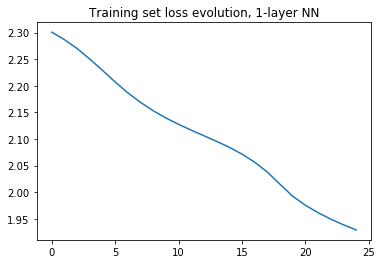

In [19]:
plt.plot(train_losses)
plt.title("Training set loss evolution, 1-layer NN")

Test set accuracy evolution:

Text(0.5,1,'Test set accuracy evolution, 1-layer NN')

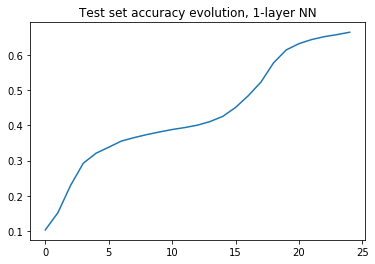

In [20]:
plt.plot(test_accuracies)
plt.title("Test set accuracy evolution, 1-layer NN")

# 2. Add More Layers

<img src="figs/8-comic2.png" style="width: 500px;"/>

Now, let's improve the recognition accuracy by adding more layers to the neural network. The neurons in the second layer, instead of computing weighted sums of pixels will compute weighted sums of neuron outputs from the previous layer. We keep the softmax function as the activation function on the last layer, but on intermediate layers we will use the the **sigmoid** activation function. So, let's build a five-layer fully connected neural network with the following structure, and train the model with the trainging data and print out its accuracy on the test data.
<img src="figs/9-five_layer.png" style="width: 500px;"/>

In [21]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with five layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1 [200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2 [100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3 [60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4 [30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5 [10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, [None, 28, 28, 1], name="input")
Y = tf.placeholder(tf.float32, shape=(None, 10), name="labels")

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.1), name="weigths1")
B1 = tf.zeros([200], name="bias1")

W2 = tf.Variable(tf.truncated_normal([200, 100], stddev=0.1), name="weigths2")
B2 = tf.zeros([100], name="bias2")

W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1), name="weigths3")
B3 = tf.zeros([60], name="bias3")

W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.1), name="weigths4")
B4 = tf.zeros([30], name="bias4")

W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1), name="weigths5")
B5 = tf.zeros([10], name="bias5")

########################################
# build the model
########################################
XX = XX = tf.reshape(X, [-1, 784], name="input_flattened")

Y1_hat = tf.nn.sigmoid(tf.add(tf.matmul(XX, W1), B1), name="out1")
Y2_hat = tf.nn.sigmoid(tf.add(tf.matmul(Y1_hat, W2), B2), name="out2")
Y3_hat = tf.nn.sigmoid(tf.add(tf.matmul(Y2_hat, W3), B3), name="out3")
Y4_hat = tf.nn.sigmoid(tf.add(tf.matmul(Y3_hat, W4), B4), name="out4")
Y_hat = tf.nn.softmax(tf.add(tf.matmul(Y4_hat, W5), B5), name="out_final")

########################################
# define the cost function
########################################
cross_entropy = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels= Y, logits=Y_hat))

########################################
# define the optimizer
########################################
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.005)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 5000

X_train_temp, Y_train = mnist.train.images, mnist.train.labels
X_train = np.reshape(X_train_temp, (-1, 28, 28, 1))

test_accuracies = []

predictions = tf.equal(tf.argmax(Y_hat, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))

X_test_temp, Y_test = mnist.test.images, mnist.test.labels
X_test = np.reshape(X_test_temp, (-1, 28, 28, 1))

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(n_epochs):
        
        X_batch_temp, Y_batch = mnist.train.next_batch(100)
        X_batch = np.reshape(X_batch_temp, (-1, 28, 28, 1))
        
        sess.run(train_step, feed_dict={X: X_batch, Y: Y_batch})
        
        if i % 200 == 0:
            train_loss = sess.run(cross_entropy, feed_dict={X: X_train, Y: Y_train})
            print(f'Train set loss for update step {i}: {train_loss}')
            train_losses.append(train_loss)
            test_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test})
            print(f'Test set accuracy for update step {i}:  {round(test_accuracy*100, 2)}%')
            test_accuracies.append(test_accuracy)
    
    test_set_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test})

    print('--------------------------------')
    print()
    print(f'Final test set accuracy: {round(test_set_accuracy*100, 2)}%')    

Train set loss for update step 0: 2.303039312362671
Test set accuracy for update step 0:  9.58%
Train set loss for update step 200: 2.3029861450195312
Test set accuracy for update step 200:  9.58%
Train set loss for update step 400: 2.303007125854492
Test set accuracy for update step 400:  9.58%
Train set loss for update step 600: 2.3029847145080566
Test set accuracy for update step 600:  9.58%
Train set loss for update step 800: 2.302967071533203
Test set accuracy for update step 800:  9.58%
Train set loss for update step 1000: 2.3030567169189453
Test set accuracy for update step 1000:  9.58%
Train set loss for update step 1200: 2.3030788898468018
Test set accuracy for update step 1200:  9.58%


KeyboardInterrupt: 

Text(0.5,1,'Multi-layer NN training set cross entropy loss evolution')

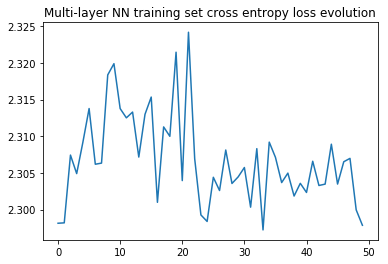

In [27]:
plt.plot(train_losses)
plt.title("Multi-layer NN training set cross entropy loss evolution")

---
# 3. Special Care for Deep Networks
As layers were added, neural networks tended to converge with more difficulties. For example, the accuracy could stuck at 0.1. Here, we want to apply some updates to the network we built in the previous part to improve its performance. 

### ReLU Activation Function
<img src="figs/10-comic3.png" style="width: 500px;"/>
The sigmoid activation function is actually quite problematic in deep networks. It squashes all values between 0 and 1 and when you do so repeatedly, neuron outputs and their gradients can vanish entirely. An alternative activation function is **ReLU** that shows better performance compare to sigmoid. It looks like as below:
<img src="figs/11-relu.png" style="width: 300px;"/>

### A Better Optimizer
In very high dimensional spaces like here, **saddle points** are frequent. These are points that are not local minima, but where the gradient is nevertheless zero and the gradient descent optimizer stays stuck there. One possible solution to tackle this probelm is to use better optimizers, such as Adam optimizer `tf.train.AdamOptimizer`.

### Random Initialisations
When working with ReLUs, the best practice is to initialise bias values to small positive values, so that neurons operate in the non-zero range of the ReLU initially.

### Learning Rate
<img src="figs/12-comic4.png" style="width: 500px;"/>
With two, three or four intermediate layers, you can now get close to 98% accuracy, if you push the iterations to 5000 or beyond. But, the results are not very consistent, and the curves jump up and down by a whole percent. A good solution is to start fast and decay the learning rate exponentially from $0.005$ to $0.0001$ for example. In order to pass a different learning rate to the `AdamOptimizer` at each iteration, you will need to define a new placeholder and feed it a new value at each iteration through `feed_dict`. Here is the formula for exponential decay: $learning\_rate = lr\_min + (lr\_max - lr\_min) * e^{\frac{-i}{2000}}$, where $i$ is the iteration number.

### NaN?
In the network you built in the last section, you might see accuracy curve crashes and the console outputs NaN for the cross-entropy. It may happen, because you are attempting to compute a $log(0)$, which is indeed Not A Number (NaN). Remember that the cross-entropy involves a log, computed on the output of the softmax layer. Since softmax is essentially an exponential, which is never zero, we should be fine, but with 32 bit precision floating-point operations, exp(-100) is already a genuine zero. TensorFlow has a handy function that computes the softmax and the cross-entropy in a single step, implemented in a numerically stable way. To use it, you will need to separate the weighted sum plus bias on the last layer, before softmax is applied and then give it with the true values to the function `tf.nn.softmax_cross_entropy_with_logits`.

In the code below, apply the following changes and show their impact on the accuracy of the model on training data, as well as the test data:
* Replace the sigmoid activation function with ReLU
* Use the Adam optimizer
* Initialize weights with small random values between -0.2 and +0.2, and make sure biases are initialised with small positive values, for example 0.1
* Update the learning rate in different iterations. Start fast and decay the learning rate exponentially from $0.005$ to $0.0001$, i.e., 
```
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0
```
* Use `tf.nn.softmax_cross_entropy_with_logits` to prevent getting NaN in output.

In [51]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with 5 layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2[100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3[60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4[30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, [None, 28, 28, 1], name="input")
Y = tf.placeholder(tf.float32, shape=(None, 10), name="labels")

# variable learning rate
learning_rate = tf.placeholder(tf.float32, shape=[])

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
# when using RELUs, make sure biases are initialised with small positive values, for example 0.1

bias_initializer = tf.constant_initializer(value=0.1)

W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.2), name="weigths1")
B1 = tf.get_variable("bias1", shape=[200], initializer=bias_initializer)

W2 = tf.Variable(tf.truncated_normal([200, 100], stddev=0.2), name="weigths2")
B2 = tf.get_variable("bias2", shape=[100], initializer=bias_initializer)

W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.2), name="weigths3")
B3 = tf.get_variable("bias3", shape=[60], initializer=bias_initializer)

W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.2), name="weigths4")
B4 = tf.get_variable("bias4", shape=[30], initializer=bias_initializer)

W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.2), name="weigths5")
B5 = tf.get_variable("bias5", shape=[10], initializer=bias_initializer)

########################################
# build the model
########################################
XX = XX = XX = tf.reshape(X, [-1, 784], name="input_flattened")

Y1_hat = tf.nn.relu(tf.add(tf.matmul(XX, W1), B1), name="out1")
Y2_hat = tf.nn.relu(tf.add(tf.matmul(Y1_hat, W2), B2), name="out2")
Y3_hat = tf.nn.relu(tf.add(tf.matmul(Y2_hat, W3), B3), name="out3")
Y4_hat = tf.nn.relu(tf.add(tf.matmul(Y3_hat, W4), B4), name="out4")
Y_hat = tf.nn.softmax(tf.add(tf.matmul(Y4_hat, W5), B5), name="out_final")

########################################
# defining the cost function
########################################
cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=Y_hat)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define the optimizer
########################################
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 5000

max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0

train_losses = []
test_accuracies = []
learning_rates= []

predictions = tf.equal(tf.argmax(Y_hat, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))

X_train_temp, Y_train = mnist.train.images, mnist.train.labels
X_train = np.reshape(X_train_temp, (-1, 28, 28, 1))

X_test_temp, Y_test = mnist.test.images, mnist.test.labels
X_test = np.reshape(X_test_temp, (-1, 28, 28, 1))
    
# checks if learning rate has reached its minimum value
flag = False

new_learning_rate = max_learning_rate

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        
        X_batch_temp, Y_batch = mnist.train.next_batch(100)
        X_batch = np.reshape(X_batch_temp, (-1, 28, 28, 1))

        if not flag:
            new_learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-epoch / 2000)
            if new_learning_rate < min_learning_rate:
                flag = True
                new_learning_rate = min_learning_rate
        learning_rates.append(new_learning_rate)

        sess.run(train_step, feed_dict={X: X_batch, Y: Y_batch, learning_rate: new_learning_rate})
                    
        if epoch % 200 == 0:
            train_loss = sess.run(cross_entropy, feed_dict={X: X_train, Y: Y_train, learning_rate: new_learning_rate})
            print(f'Training set loss in update step {epoch}: {train_loss}')
            train_losses.append(train_loss)
            test_set_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test, learning_rate: new_learning_rate})
            print(f'Test set accuracy in update step {epoch}: {round(test_set_accuracy*100, 2)}%') 
            test_accuracies.append(test_accuracies)

    new_learning_rate = max(min_learning_rate, min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-n_epochs / 2000))

    test_set_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test, learning_rate: new_learning_rate})
    print('--------------------------------')
    print()
    print(f'Final test set accuracy: {round(test_set_accuracy*100, 2)}%') 
        

Training set loss in update step 0: 226.87652587890625
Test set accuracy in update step 0: 16.38%
Training set loss in update step 200: 165.29808044433594
Test set accuracy in update step 200: 81.12%
Training set loss in update step 400: 162.68455505371094
Test set accuracy in update step 400: 83.32%
Training set loss in update step 600: 162.4935302734375
Test set accuracy in update step 600: 83.92%
Training set loss in update step 800: 161.27606201171875
Test set accuracy in update step 800: 84.81%
Training set loss in update step 1000: 160.5447235107422
Test set accuracy in update step 1000: 85.33%
Training set loss in update step 1200: 152.92726135253906
Test set accuracy in update step 1200: 92.67%
Training set loss in update step 1400: 152.2083282470703
Test set accuracy in update step 1400: 93.58%
Training set loss in update step 1600: 151.12818908691406
Test set accuracy in update step 1600: 94.84%
Training set loss in update step 1800: 150.52760314941406
Test set accuracy in up

Text(0.5,1,'Training set loss, multi-Layer NN with ReLU activation')

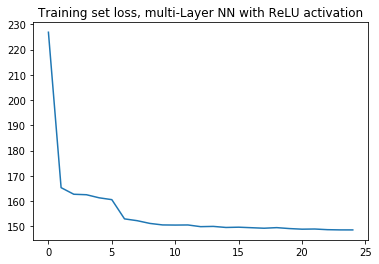

In [52]:
plt.plot(train_losses)
plt.title("Training set loss, multi-Layer NN with ReLU activation")

In [ ]:
plt.plot(test_accuracies)
plt.title("Test set accuracy, multi-Layer NN with ReLU activation")

---
# 4. Overfitting and Dropout
<img src="figs/13-comic5.png" style="width: 500px;"/>
You will have noticed that cross-entropy curves for test and training data start disconnecting after a couple thousand iterations. The learning algorithm works on training data only and optimises the training cross-entropy accordingly. It never sees test data so it is not surprising that after a while its work no longer has an effect on the test cross-entropy which stops dropping and sometimes even bounces back up. 
<img src="figs/14-overfit.png" style="width: 500px;"/>
This disconnect is usually labeled **overfitting** and when you see it, you can try to apply a regularisation technique called **dropout**. In dropout, at each training iteration, you drop random neurons from the network. You choose a probability `pkeep` for a neuron to be kept, usually between 50% and 75%, and then at each iteration of the training loop, you randomly remove neurons with all their weights and biases. Different neurons will be dropped at each iteration. When testing the performance of your network of course you put all the neurons back (`pkeep = 1`).
<img src="figs/15-dropout.png" style="width: 500px;"/>
TensorFlow offers a dropout function to be used on the outputs of a layer of neurons. It randomly zeroes-out some of the outputs and boosts the remaining ones by `1 / pkeep`. You can add dropout after each intermediate layer in the network now. 

In the following code, use the dropout between each layer during the training, and set the probability `pkeep` once to $50%$ and another time to $75%$ and compare their results.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with 5 layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2[100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3[60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4[30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = <FILL IN>
Y = <FILL IN>

# variable learning rate
learning_rate = <FILL IN>

# probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = <FILL IN>

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
# when using RELUs, make sure biases are initialised with small positive values, for example 0.1
W1 = <FILL IN>
B1 = <FILL IN>

W2 = <FILL IN>
B2 = <FILL IN>

W3 = <FILL IN>
B3 = <FILL IN>

W4 = <FILL IN>
B4 = <FILL IN>

W5 = <FILL IN>
B5 = <FILL IN>

########################################
# build the model
########################################
XX = <FILL IN>

Y1_hat = <FILL IN>
Y1_hat_dropout = <FILL IN>
Y2_hat_dropout = <FILL IN>
Y3_hat_dropout = <FILL IN>
Y4_hat_dropout = <FILL IN>
Y_hat = <FILL IN>

########################################
# define the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(<FILL IN>)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define the optimizer
########################################
optimizer = <FILL IN>
train_step = optimizer.<FILL IN>

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 5000
with tf.Session() as sess:
    <FILL IN>

---
# 6. Convolutional Network
<img src="figs/16-comic6.png" style="width: 500px;"/>
In the previous sections, all pixels of images flattened into a single vector, which was a really bad idea. Handwritten digits are made of shapes and we discarded the shape information when we flattened the pixels. However, we can use **convolutional neural networks (CNN)** to take advantage of shape information. CNNs apply *a series of filters* to the raw pixel data of an image to extract and learn higher-level features, which the model can then use for classification. CNNs contains three components:
  - **Convolutional layers**: apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.
  - **Pooling layers**: downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.
  - **Dense (fully connected) layers**: perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.
  
Typically, a CNN is composed of a *stack of **convolutional modules*** that perform feature extraction. Each *module* consists of a *convolutional layer* followed by a *pooling layer*. The last convolutional module is followed by one or more dense layers that perform classification. The final dense layer in a CNN contains a single neuron for each target class in the model, with a softmax activation function to generate a value between 0-1 for each neuron. We can interpret the softmax values for a given image as relative measurements of how likely it is that the image falls into each target class.

Now, let us build a convolutional network for handwritten digit recognition. In this assignment, we will use the architecture shown in the following figure that has three convolutional layers, one fully-connected layer, and one softmax layer. Notice that the second and third convolutional layers have a stride of two that explains why they bring the number of output values down from 28x28 to 14x14 and then 7x7. A convolutional layer requires a weights tensor like `[4, 4, 3, 2]`, in which the first two numbers define the size of a filter (map), the third number shows the *depth* of the filter that is the number of *input channel*, and the last number shows the number of *output channel*. The output channel defines the number of times that we repeat the same thing with a different set of weights in one layer. In our implementation, we assume the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected layer is 200.
<img src="figs/17-arch1.png" style="width: 600px;"/>

Convolutional layers can be implemented in TensorFlow using the `tf.nn.conv2d` function, which performs the scanning of the input image in both directions using the supplied weights. This is only the weighted sum part of the neuron. You still need to add a bias and feed the result through an activation function. The padding strategy that works here is to copy pixels from the sides of the image. All digits are on a uniform background so this just extends the background and should not add any unwanted shapes.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# · · · · · · · · · ·      (input data, 1-deep)               X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @   -- conv. layer 5x5x1=>4 stride 1      W1 [5, 5, 1, 4]        B1 [4]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 4]
#   @ @ @ @ @ @ @ @     -- conv. layer 5x5x4=>8 stride 2      W2 [5, 5, 4, 8]        B2 [8]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 8]
#     @ @ @ @ @ @       -- conv. layer 4x4x8=>12 stride 2     W3 [4, 4, 8, 12]       B3 [12]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 12] => reshaped to YY [batch, 7*7*12]
#      \x/x\x\x/        -- fully connected layer (relu)       W4 [7*7*12, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/         -- fully connected layer (softmax)    W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = <FILL IN>
Y = <FILL IN>
learning_rate = <FILL IN>

# three convolutional layers with their channel counts, and a fully connected layer 
# (the last layer has 10 softmax neurons)
# the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected
# layer is 200
W1 = <FILL IN>
B1 = <FILL IN>

W2 = <FILL IN>
B2 = <FILL IN>

W3 = <FILL IN>
B3 = <FILL IN>

W4 = <FILL IN>
B4 = <FILL IN>

W5 = <FILL IN>
B5 = <FILL IN>

########################################
# build the model
########################################
stride = 1  # output is 28x28
Y1_hat = <FILL IN> # use tf.nn.conv2d

stride = 2  # output is 14x14
Y2_hat = <FILL IN>

stride = 2  # output is 7x7
Y3_hat = <FILL IN>

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(<FILL IN>)
Y4_hat = <FILL IN>
Y_hat = <FILL IN>

########################################
# define the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(<FILL IN>)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define the optmizer
########################################
optimizer = <FILL IN>
train_step = optimizer.minimize(<FILL IN>)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 5000
with tf.Session() as sess:
    <FILL IN>

# 7. Improve The Performance
A good approach to sizing your neural networks is to implement a network that is a little too constrained, then give it a bit more degrees of freedom and add dropout to make sure it is not overfitting. This ends up with a fairly optimal network for your problem. In the above model, we set the output channel to 4 in the first convolutional layer, which means that we repeat the same filter shape (but with different weights) four times. If we assume that those filters evolve during training into shape recognisers, you can intuitively see that this might not be enough for our problem. Handwritten digits are made from more than 4 elemental shapes. So let us bump up the filter sizes a little, and also increase the number of filters in our convolutional layers from 4, 8, 12 to 6, 12, 24 and then add dropout on the fully-connected layer. The following figure shows the new architecture you should build. Please complete the following code based on the given architecture and dropout technique.
<img src="figs/18-arch2.png" style="width: 600px;"/>

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [5, 5, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = <FILL IN>
Y = <FILL IN>
lr = <FILL IN>
pkeep = <FILL IN>

# three convolutional layers with their channel counts, and a fully connected layer 
# (the last layer has 10 softmax neurons)
# the output depth of first three convolutional layers, are 6, 12, 24, and the size of fully connected
# layer is 200
W1 = <FILL IN>
B1 = <FILL IN>

W2 = <FILL IN>
B2 = <FILL IN>

W3 = <FILL IN>
B3 = <FILL IN>

W4 = <FILL IN>
B4 = <FILL IN>

W5 = <FILL IN>
B5 = <FILL IN>

########################################
# build the model
########################################
stride = 1  # output is 28x28
Y1_hat = <FILL IN>

stride = 2  # output is 14x14
Y2_hat = <FILL IN>

stride = 2  # output is 7x7
Y3_hat = <FILL IN>

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(<FILL IN>)
Y4_hat = <FILL IN>
YY4_hat = tf.nn.dropout(<FILL IN>
Y_hat = <FILL IN>

########################################
# define the Loss function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(<FILL IN>)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# traini the model
########################################
optimizer = <FILL IN>
train_step = optimizer.<FILL IN>

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 2000
with tf.Session() as sess:
    <FILL IN>

---
# 8. Tensorflow Layers Module
The TensorFlow **layers** `tf.layers` module provides a high-level API that makes it easy to construct a neural network. It provides methods that facilitate: (i) the creation of dense (fully connected) layers and convolutional layers, (ii) adding activation functions, and (iii) applying dropout regularization. In this section use the module `tf.layers` to build the network you made in section 7.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# to reset the Tensorflow default graph
reset_graph()

<FILL IN> # :)

---
# 9. Keras
Keras is a high-level API to build and train deep learning models. It's used for fast prototyping, advanced research, and production. `tf.keras` is TensorFlow's implementation of the Keras API specification. To work with Keras, you need to import `tf.keras` as part of your TensorFlow program setup.
```
import tensorflow as tf
from tensorflow.keras import layers
```
#### Build a model
In Keras, you assemble **layers** to build a model, i.e., a graph of layers. The most common type of model is a stack of layers: the `tf.keras.Sequential` model. For example, the following code builds a simple, fully-connected network (i.e., multi-layer perceptron):
```
model = tf.keras.Sequential()
# adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation='relu'))
# add another
model.add(layers.Dense(64, activation='relu'))
# add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))
```
There are many `tf.keras.layers` available with some common constructor parameters:
* `activation`: set the activation function for the layer, which is specified by the name of a built-in function or as a callable object.
* `kernel_initializer` and `bias_initializer`: the initialization schemes that create the layer's weights (weight and bias).
* `kernel_regularizer` and `bias_regularizer`: the regularization schemes that apply the layer's weights (weight and bias), such as L1 or L2 regularization.

#### Train and evaluate
After you construct a model, you can configure its learning process by calling the `compile` method:
```
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
```
The method `tf.keras.Model.compile` takes three important arguments:
* `optimizer`: it specifies the training procedure, e.g., `tf.train.AdamOptimizer` and `tf.train.GradientDescentOptimizer`.
* `loss`: the cost function to minimize during optimization, e.g., mean square error (mse), categorical_crossentropy, and binary_crossentropy.
* `metrics`: used to monitor training, e.g., `accuracy`.

The next step after confiuring the model is to train it by calling the `model.fit` method and giving it training data as its input. After training the model you can call `tf.keras.Model.evaluate` and `tf.keras.Model.predict` methods to evaluate the inference-mode loss and metrics for the data provided or predict the output of the last layer in inference for the data provided, respectively.

You can read more about Keras [here](https://www.tensorflow.org/guide/keras).

In this task, please use Keras to rebuild the network you made in section 7.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# to reset the Tensorflow default graph
reset_graph()

<FILL IN> # :)

---
# 10. Implement LeNet-5
In this section, you should implement **LeNet-5** either using Tensorflow or Keras. Please take a look at its [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) before starting to implement it.
The LeNet-5 architecture is perhaps the most widely known CNN architecture. It was created by Yann LeCun in 1998 and widely used for handwritten digit recognition (MNIST). It is composed of the layers shown in the following table.
<img src="figs/19-letnet5.png" style="width: 600px;"/>
There are a few extra details to be noted:
* MNIST images are 28×28 pixels, but they are zero-padded to 32×32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient and adds a learnable bias term, then finally applies the activation function.
* Most neurons in layer C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 in the [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) for details.
* The output layer is a bit special: instead of computing the dot product of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and thus converging faster.

In [ ]:
# TODO: Build the LetNet-5 model, and test it on MNIST

# to reset the Tensorflow default graph
reset_graph()

---
# 11. Implement AlexNet
In the last section, you should implement **AlexNet** either using Tensorflow or Keras. Again, please take a look at its [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) before start to implement it.
The AlexNet CNN architecture won the [ImageNet ILSVRC challenge](http://www.image-net.org/challenges/LSVRC/2012/) in 2012 by a large margin. It was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. It is quite similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. The following table presents this architecture.
<img src="figs/20-alexnet.png" style="width: 600px;"/>
To train the model, we need a big dataset, however, in this assignment you are going to to assign the pretrained weights to your model, using `tf.Variable.assign`. You can download the pretrained weights from [bvlc_alexnet.npy](https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy). This file is a NumPy array file created by the python. After you read this file, you will receive a python dictionary with a <key, value> pair for each layer. Each key is one of the layers names, e.g., `conv1`, and each value is a list of two values: (1) weights, and (2) biases of that layer. Part of the function to load the weights and biases to your model is given, and you need to complete it.

Here is what you see if you read and print the shape of each layer from the file:
```
weight_dic = np.load("bvlc_alexnet.npy", encoding="bytes").item()
for layer in weights_dic:
    print("-" * 20)
    print(layer)
    for wb in weights_dic[layer]:
        print(wb.shape)

#--------------------
# fc8
# (4096, 1000) # weights
# (1000,) # bias
#--------------------
# fc7
# (4096, 4096) # weights
# (4096,) # bias
#--------------------
# fc6
# (9216, 4096) # weights
# (4096,) # bias
#--------------------
# conv5
# (3, 3, 192, 256) # weights
# (256,) # bias
#--------------------
# conv4
# (3, 3, 192, 384) # weights
# (384,) # bias
#--------------------
# conv3
# (3, 3, 256, 384) # weights
# (384,) # bias
#--------------------
# conv2
# (5, 5, 48, 256) # weights
# (256,) # bias
#--------------------
# conv1
# (11, 11, 3, 96) # weights
# (96,) # bias
```


In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# to reset the Tensorflow default graph
reset_graph()

# build the AlexNet model
<FILL IN> :)

# load inital weights and biases to the model
def load_initial_weights(self, session):
    # load the weights into memory
    weights_dic = np.load('bvlc_alexnet.npy', encoding='bytes').item()

    # loop over all layer names stored in the weights dict
    for layer in weights_dict:
        with tf.variable_scope(layer, reuse=True):
            # loop over list of weights/biases and assign them to their corresponding tf variable
            for wb in weights_dict[layer]:
                # biases
                if len(wb.shape) == 1:
                    bias = tf.get_variable(<FILL IN>)
                    session.run(bias.assign(wb))
                # weights
                else:
                    weight = tf.get_variable(<FILL IN>)
                    session.run(weight.assign(wb))
                

#### Test the model
After building the AlexNet model, you can test it on different images and present the accuracy of the model. To do so, first you need to use **OpenCV** library to make the images ready to give as input to the model. OpenCV is a library used for image processing. Below you can see how to read an image file and pre-process it using OpenCV to give it to the model. However, you need to complete the code and test the accuracy of your model. The teset images (shown below) are available in the `test_images` folder.
<table width="100%">
<tr>
<td><img src="test_images/test_image1.jpg" style="width:200px;"></td>
<td><p align="center"><img src="test_images/test_image2.jpg" style="width:200px;"></td>
<td align="right"><img src="test_images/test_image3.jpg" style="width:200px;"></td>
</tr>

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
# test the AlexNet model on the given images

import cv2

#get list of all images
current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'test_images')
img_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.jpg')]

#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))

with tf.Session() as sess:
    <FILL IN>
    
    # loop over all images
    for i, image in enumerate(imgs):
        # convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227, 227))
        
        # subtract the ImageNet mean
        # Mean subtraction per channel was used to center the data around zero mean for each channel (R, G, B).
        # This typically helps the network to learn faster since gradients act uniformly for each channel.
        imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)
        img -= imagenet_mean
        
        # reshape as needed to feed into model
        img = img.reshape((1, 227, 227, 3))
        
        <FILL IN>